# Attack pipeline on Adult using a Decision Tree as explainer

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("../../")
sys.path.append("../../lime/")
import mlem
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils import shuffle
from sklearn import tree
from pathlib import Path

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
from mlem.utilities import save_pickle_bz2, load_pickle_bz2

# DATA LOADING AND CONFIGURATION

In [3]:
from mlem.utilities import load_pickle_bz2

data for the attack

In [4]:
BLACK_BOX = load_pickle_bz2("../datasets/adult/BB_NO_CLUSTERING/BB_DATA/adult_rf_noclustering.bz2")
# x_train x_test y_train y_test x_test_clustered y_test_clustered
BLACK_BOX_DATA = np.load("../datasets/adult/BB_NO_CLUSTERING/BB_DATA/adult_rf_noclustering_data_nsamples_2.npz")
# on the version of diva we're using all the features are numeric
CATEGORICAL_FEATURES_MASK = ADULT_CATEGORICAL_FEATURES_MASK = [False,
                                       True,
                                       False,
                                       True,
                                       False,
                                       True,
                                       True,
                                       True,
                                       True,
                                       True,
                                       False,
                                       False,
                                       False,
                                       True]

In [5]:
train_distr = pd.DataFrame(BLACK_BOX_DATA['y_train']).value_counts(normalize=True)
test_distr = pd.DataFrame(BLACK_BOX_DATA['y_test']).value_counts(normalize=True)

In [6]:
print(f"train size = {len(BLACK_BOX_DATA['y_train'])} | test size = {len(BLACK_BOX_DATA['y_test'])} | total size = {len(BLACK_BOX_DATA['y_train']) + len(BLACK_BOX_DATA['y_test'])}")
print(f"train distribution:\n{train_distr}\n")
print(f"test distribution:\n{test_distr}")

train size = 16877 | test size = 7234 | total size = 24111
train distribution:
0    0.750963
1    0.249037
dtype: float64

test distribution:
0    0.750899
1    0.249101
dtype: float64


X and Y are the row to attack

In [7]:
INDEX = 0

In [8]:
X = BLACK_BOX_DATA['x_test_clustered'][INDEX]
Y = BLACK_BOX_DATA['y_test_clustered'][INDEX]

### building the explainer

Training the explainer on the training data of the black box

In [9]:
explainer_training_data = BLACK_BOX_DATA['x_train']
explainer = LimeTabularExplainer(training_data=explainer_training_data, categorical_features=[i for (i, el) in enumerate(CATEGORICAL_FEATURES_MASK) if el], random_state=123)

# Attack Pipeline

## 1) Creating the local explainer

at the end of this section the important variables will be:
* `local_model` : contains the local model (the ensemble classifier generated by LIME)
* `x_neigh` : contains the neighborhood generated by LIME
* `y_neigh`: contains the classification of `x_neigh` generated by the local_model

This code is contained in the `__get_local_data` function in the mlem code

In [10]:
explanations, lime_models, x_neigh = explainer.explain_instance(X, BLACK_BOX.predict_proba, labels=[0,1], sampling_method="gaussian", num_samples=5000, num_features=len(X))

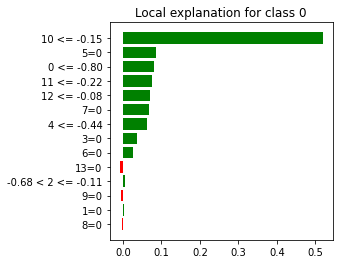

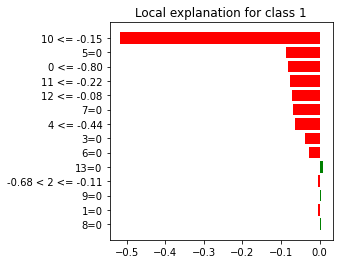

In [11]:
fig0 = explanations.as_pyplot_figure(label=0)
fig1 = explanations.as_pyplot_figure(label=1)

Difference between the points in the neighborhood and the original instance.

*The instances generated by LIME are not very close to the original instance, maybe we could generate neighborhoods in a loop and keep only the closest elements*

In [12]:
from mlem.utilities import norm_nocategorical
difference_from_X_cat = [np.linalg.norm(x_neigh[0]-x) for x in x_neigh]
difference_from_X_nocat = [norm_nocategorical(x_neigh[0]-x, CATEGORICAL_FEATURES_MASK) for x in x_neigh]
print(f"with cat:\tmax = {max(difference_from_X_cat[1:]):.2f} min = {min(difference_from_X_cat[1:]):.2f} avg = {np.average(difference_from_X_cat[1:]):.2f} std= {np.std(difference_from_X_cat[1:]):.2f}")
print(f"without cat:\tmax = {max(difference_from_X_nocat[1:]):.2f} min = {min(difference_from_X_nocat[1:]):.2f} avg = {np.average(difference_from_X_nocat[1:]):.2f} std= {np.std(difference_from_X_nocat[1:]):.2f}")

with cat:	max = 11.50 min = 0.55 avg = 2.75 std= 1.22
without cat:	max = 11.49 min = 0.42 avg = 2.69 std= 1.24


Creating the local model as ensamble of the models returned by lime

In [13]:
attack_dataset = pd.DataFrame(x_neigh)
attack_dataset['Target'] = BLACK_BOX.predict(attack_dataset.to_numpy())

In [14]:
attack_dataset.Target.value_counts()

0    4485
1     515
Name: Target, dtype: int64

In [15]:
def generate_balanced_dataset(x, num_samples, black_box, explainer, max_tries=15, shuffle=True, verbose=False):
    generated = pd.DataFrame(explainer.data_inverse(x, 5000, 'gaussian')[1])
    generated['Target'] = black_box.predict(generated.to_numpy())
    min_class =-np.NINF
    final = pd.DataFrame()
    for t in range(max_tries):
        if verbose:
            print(f"try number {t}")
        
        if len(final) >= num_samples:
            
            return final.sample(frac=1) if shuffle else final
        
        generated = pd.DataFrame(explainer.data_inverse(x, 5000, 'gaussian')[1])
        generated['Target'] = black_box.predict(generated.to_numpy())
        
        zeroes = generated[generated['Target'] == 0]
        ones   = generated[generated['Target'] == 1]
        
        if len(zeroes) == 0 or len(ones) == 0:
            continue
        
        if len(final) < num_samples:
            min_len = min(len(zeroes), len(ones))
            final = pd.concat([final, zeroes.head(min_len).copy(), ones.head(min_len).copy()])
    
        if verbose:
            p0, p1 = final.Target.value_counts(normalize=True)
            print(f"{len(final)=} {p0=} {p1=}")
        
        
    raise Exception("Could not generate balanced dataset")


In [16]:
#g = generate_balanced_dataset(X, 5000, BLACK_BOX, explainer, 20, True, True)

try number 0
len(final)=1014 p0=0.5 p1=0.5
try number 1
len(final)=2020 p0=0.5 p1=0.5
try number 2
len(final)=3032 p0=0.5 p1=0.5
try number 3
len(final)=4008 p0=0.5 p1=0.5
try number 4
len(final)=4996 p0=0.5 p1=0.5
try number 5
len(final)=5960 p0=0.5 p1=0.5
try number 6


In [17]:
#g.to_csv("adult_lime_generated_around_0.csv", index=False)

In [16]:
generated_dataset = pd.read_csv("adult_lime_generated_around_0.csv")

In [17]:
ATTACK_DATASET = generated_dataset.copy()

In [18]:
ATTACK_DATASET

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Target
0,0.409510,0.558659,-0.844732,0.421658,0.359433,0.048399,0.270647,0.106689,0.263855,0.113783,-0.000003,0.000000,0.409809,0.049180,0
1,-0.208209,0.218918,-1.410832,0.164328,1.013728,0.048399,0.124236,0.455728,0.263855,0.113783,1.086590,0.000000,1.542178,0.254411,1
2,-0.633597,0.218918,-1.233630,0.164328,-1.535673,0.455011,0.202926,0.066334,0.263855,0.313955,-0.000003,3.879882,-1.304366,0.375000,0
3,-1.265526,0.218918,-0.965305,0.164328,-1.738403,0.455011,0.448686,0.106689,0.263855,0.313955,-0.000003,0.000000,-0.512544,0.254411,0
4,2.543788,0.218918,-0.847469,0.421658,-0.954022,0.048399,0.326087,0.455728,0.118881,0.113783,-0.000003,0.000000,1.143054,0.254411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,-0.479600,0.218918,-0.387703,0.164328,0.971225,0.455011,0.124236,0.106689,0.263855,0.313955,5.616319,0.000000,-2.137192,0.352941,1
5956,-0.645313,0.218918,-1.348159,0.200180,-1.878411,0.455011,0.225590,0.014343,0.263855,0.313955,-0.000003,0.000000,0.779427,0.254411,0
5957,-1.231821,0.218918,0.069874,0.421658,1.891847,0.455011,0.061527,0.455728,0.263855,0.313955,4.326577,0.000000,-1.509275,0.254411,1
5958,0.454095,0.268960,2.038795,0.200180,-1.668262,0.107312,0.326087,0.014343,0.263855,0.313955,-0.000003,0.000000,-1.289506,0.254411,0


In [19]:
# Hyperparameters of the grid search
__HYPERPARAMETERS = {
    "criterion": ["gini", "entropy"],
}

def create_decision_tree(
        x_train,
        y_train,
        hyperparameters = __HYPERPARAMETERS,
        n_jobs=4,
        use_halving=True
):
    """Creates a random forest classifier via grid search.

    Args:
        x_train (ndarray): Training input examples.
        y_train (ndarray): Training target values.
        hyperparameters (Dict[str, List[Any]], optional): Dictionary of hyperparameters for the grid search. Defaults to the fixed ones.
        n_jobs: Number of jobs to run in parallel in the grid search. (default 4)
        use_halving (bool): If true use the HalvingGridSearch

    Returns:
        RandomForestClassifier: Random forest classifier.
    """

    dt = tree.DecisionTreeClassifier()

    if use_halving:
        clf = HalvingGridSearchCV(dt, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    else:
        clf = RandomizedSearchCV(dt, hyperparameters, refit=True, n_jobs=n_jobs, verbose=0)
    clf.fit(x_train, y_train)
    # print(f"GRID_SEARCH BEST PARAMS: {clf.best_params_=}")
    return clf.best_estimator_

In [20]:
X_train, X_test, y_train, y_test = train_test_split(generated_dataset.drop('Target', axis=1).to_numpy(), generated_dataset.Target.to_numpy(), test_size=0.33, random_state=42)

In [21]:
dt = create_decision_tree(X_train, y_train, use_halving=True) if not Path("decision_tree_adult96.bz2").exists() else load_pickle_bz2("decision_tree_adult96.bz2")

In [22]:
dt

DecisionTreeClassifier()

The decision tree has good performances

In [23]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       977
           1       0.96      0.95      0.96       990

    accuracy                           0.96      1967
   macro avg       0.96      0.96      0.96      1967
weighted avg       0.96      0.96      0.96      1967



In [24]:
if not Path("decision_tree_adult96.bz2").exists():
    save_pickle_bz2("decision_tree_adult96.bz2", dt)
    np.savez("decision_tree_adult_96.data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

# Attacking the decision tree

In [32]:
from mlem.shadow_models import ShadowModelsManager

In [33]:
local_tree = load_pickle_bz2("decision_tree_adult96.bz2")
loaded     = np.load("decision_tree_adult_96.data.npz", allow_pickle=True)

In [34]:
X_train = loaded['X_train']
X_test  = loaded['X_test']
y_train = loaded['y_train']
y_test  = loaded['y_test']
full_generated_dataset = pd.read_csv("adult_lime_generated_around_0.csv")

Using the lime generated dataset as x_attack and the labels computed by the dt as y_attack

In [35]:
x_attack = full_generated_dataset.drop('Target', axis=1)
y_attack = local_tree.predict(x_attack.to_numpy())

In [36]:
(y_attack == full_generated_dataset.Target).value_counts(normalize=True)

True     0.986074
False    0.013926
Name: Target, dtype: float64

### with Adaboost

In [36]:
from mlem.utilities import create_adaboost

path="DT/shadow_adab_adult_dt"

shadow_models = ShadowModelsManager(
        n_models=4,
        results_path=f"{path}/shadow",
        test_size=0.5,
        random_state=123,
        model_creator_fn=create_adaboost,
        categorical_mask=CATEGORICAL_FEATURES_MASK
    )

Fitting 4 shadow models on the data

In [37]:
shadow_models.fit(x_attack, y_attack)

In [38]:
attack_dataset = shadow_models.get_attack_dataset()
attack_dataset

,0,1,label,inout
0,0.345676,0.654324,1,in
1,0.512916,0.487084,0,in
2,0.352808,0.647192,1,in
3,0.559475,0.440525,0,in
4,0.377655,0.622345,1,in
...,...,...,...,...
2975,0.387409,0.612591,1,out
2976,0.428386,0.571614,1,out
2977,0.423529,0.576471,1,out
2978,0.516065,0.483935,0,out


The mean and std are close to 0.5 and 0

In [39]:
attack_dataset[attack_dataset.label == 0][[0,1]].describe()

,0,1
count,11948.000000,11948.000000
mean,0.546993,0.453007
std,0.028425,0.028425
min,0.382406,0.345800
25%,0.526117,0.434317
50%,0.544676,0.455324
75%,0.565683,0.473883
max,0.654200,0.617594


In [40]:
attack_dataset[attack_dataset.label == 1][[0,1]].describe()

,0,1
count,11916.000000,11916.000000
mean,0.393322,0.606678
std,0.072308,0.072308
min,0.233449,0.437549
25%,0.329194,0.526133
50%,0.390568,0.609432
75%,0.473867,0.670806
max,0.562451,0.766551


In [41]:
attack_dataset_ins = attack_dataset[attack_dataset.inout == 'in']#.drop('inout', axis=1)
attack_dataset_outs = attack_dataset[attack_dataset.inout == 'out']#.drop('inout', axis=1)

In [42]:
int_df = pd.merge(attack_dataset_ins, attack_dataset_outs, how ='inner', on =[0, 1])

**These probability distributions appear both with the label in and out in the attack dataset**

In [43]:
int_df

,0,1,label_x,inout_x,label_y,inout_y
0,0.474281,0.525719,1,in,1,out
1,0.543477,0.456523,0,in,0,out
2,0.496158,0.503842,1,in,0,out
3,0.362655,0.637345,1,in,1,out
4,0.468624,0.531376,1,in,1,out
...,...,...,...,...,...,...
1564,0.404432,0.595568,1,in,1,out
1565,0.493020,0.506980,1,in,1,out
1566,0.493020,0.506980,1,in,1,out
1567,0.493020,0.506980,1,in,1,out


Creating the attack models, one for each label

In [44]:
from mlem.attack_models import AttackModelsManager, AttackStrategy
attack_models = AttackModelsManager(
        results_path=f"DT/attack_adab_adult_dt", model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
)

In [45]:
attack_models.fit(attack_dataset)

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling


In [46]:
atk_0 = load_pickle_bz2("DT/attack_adab_adult_dt/0/model.pkl.bz2")
atk_1 = load_pickle_bz2("DT/attack_adab_adult_dt/1/model.pkl.bz2")

### Attack on the whole datasets of the BB

In [47]:
BB_TRAIN = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_TRAIN['Target'] = BLACK_BOX_DATA['y_train']

BB_TEST = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_TEST['Target'] = BLACK_BOX_DATA['y_test']

In [48]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [49]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [50]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [51]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [52]:
BB_TRAIN_0

,0,1,ATK,Y
0,0.803145,0.196855,out,in
1,0.888638,0.111362,out,in
2,0.990708,0.009292,out,in
3,0.997404,0.002596,out,in
4,0.983742,0.016258,out,in
...,...,...,...,...
12669,0.788110,0.211890,out,in
12670,0.977904,0.022096,out,in
12671,0.997384,0.002616,out,in
12672,0.371998,0.628002,out,in


In [53]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [54]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.70      0.17      0.28     16877
         out       0.30      0.83      0.44      7234

    accuracy                           0.37     24111
   macro avg       0.50      0.50      0.36     24111
weighted avg       0.58      0.37      0.32     24111



In [55]:
train_test[train_test.Y == 'out'].ATK.value_counts()

out    6008
in     1226
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f8a01b00310>


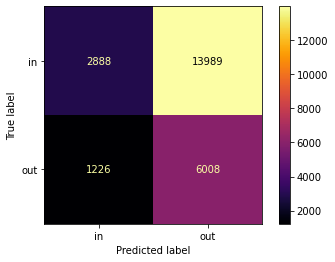

In [56]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

Let's see on the points closest to the instance used to create the neighborhood

In [57]:
import scipy.spatial.distance as distance

In [58]:
BB_DATA_TR = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_DATA_TR['Target'] = BLACK_BOX_DATA['y_train']
BB_DATA_TR['Distance'] = distance.cdist(BLACK_BOX_DATA['x_train'], [X], metric="euclidean")

BB_DATA_TE = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_DATA_TE['Target'] = BLACK_BOX_DATA['y_test']
BB_DATA_TE['Distance'] = distance.cdist(BLACK_BOX_DATA['x_test'], [X], metric="euclidean")

In [59]:
BB_DATA_TR.Distance.describe()

count    16877.000000
mean         2.501770
std          1.457291
min          0.085012
25%          1.649780
50%          2.275654
75%          3.035977
max         14.413855
Name: Distance, dtype: float64

In [60]:
BB_DATA_TE.Distance.describe()

count    7234.000000
mean        2.496813
std         1.418222
min         0.000000
25%         1.648631
50%         2.278651
75%         3.053983
max        14.435124
Name: Distance, dtype: float64

In [61]:
BB_DATA_TR[BB_DATA_TR.Distance < 2.5].Target.value_counts(normalize=True)

0    0.846397
1    0.153603
Name: Target, dtype: float64

In [62]:
BB_DATA_TE[BB_DATA_TE.Distance < 3].Target.value_counts(normalize=True)

0    0.810058
1    0.189942
Name: Target, dtype: float64

Creating the dataset with the closest points

In [63]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 2.5].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 3].drop('Distance', axis=1)

In [64]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [65]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [66]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [67]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [68]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [69]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.58      0.08      0.14      9824
         out       0.35      0.89      0.50      5349

    accuracy                           0.37     15173
   macro avg       0.46      0.49      0.32     15173
weighted avg       0.49      0.37      0.27     15173



In [70]:
train_test[train_test.Y == 'out'].ATK.value_counts()

out    4751
in      598
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f8a00a751c0>


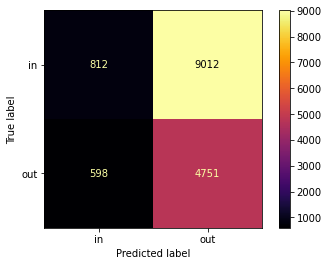

In [71]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

Creating dataset with points closer that 1

In [72]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 1].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 1].drop('Distance', axis=1)

In [73]:
BB_TRAIN

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Target
44,-1.328265,0.218918,-0.354033,0.200180,-0.048076,0.048399,0.041134,0.106689,0.129972,0.113783,-0.147502,-0.218673,-0.912857,0.254411,0
46,-0.947492,0.218918,0.659777,0.200180,-0.048076,0.048399,0.041134,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
57,-1.023647,0.218918,-0.948069,0.164328,-0.440434,0.048399,0.133907,0.014343,0.277405,0.113783,-0.147502,-0.218673,-0.078031,0.254411,0
62,-1.099801,0.218918,0.330513,0.164328,-0.440434,0.048399,0.225590,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
65,-1.099801,0.218918,0.087226,0.164328,-0.440434,0.048399,0.225590,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16755,-1.175956,0.218918,-0.044380,0.164328,-0.440434,0.048399,0.061527,0.014343,0.129972,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
16773,-0.947492,0.218918,0.560257,0.200180,-0.048076,0.048399,0.225590,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
16808,-1.099801,0.218918,-0.265832,0.164328,-0.440434,0.107312,0.485342,0.106689,0.263855,0.113783,-0.147502,-0.218673,0.339381,0.254411,1
16816,-1.480574,0.218918,-0.743568,0.164328,-0.440434,0.048399,0.270647,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0


In [74]:
BB_TEST

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Target
10,-1.328265,0.218918,0.452938,0.200180,-0.048076,0.048399,0.041134,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.495444,2.544112e-01,0
23,-0.719029,0.218918,-0.817391,0.164328,-0.440434,0.048399,0.225590,0.106689,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,0
53,-1.023647,0.268960,-0.304552,0.164328,-0.440434,0.048399,0.485342,0.106689,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,0
59,-1.252110,0.218918,0.235100,0.164328,-0.440434,0.048399,0.124236,0.106689,0.263855,0.313955,-0.147502,-0.218673,0.088934,2.544112e-01,0
86,-1.404419,0.218918,-0.048431,0.164328,-0.440434,0.048399,0.270647,0.106689,0.263855,0.113783,-0.147502,-0.218673,-0.745892,2.544112e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7182,-1.175956,0.218918,0.266580,0.164328,-0.440434,0.048399,0.225590,0.066334,0.263855,0.313955,-0.147502,-0.218673,0.339381,5.629249e-07,0
7183,-1.175956,0.218918,-0.683458,0.164328,-0.440434,0.048399,0.225590,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,0
7186,-1.023647,0.218918,0.223525,0.200180,-0.048076,0.455011,0.270647,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,1
7198,-0.871338,0.218918,-0.058264,0.164328,-0.440434,0.048399,0.202926,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,0


In [75]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [76]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [77]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [78]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [79]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [80]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.00      0.00      0.00      1352
         out       0.31      1.00      0.47       597

    accuracy                           0.31      1949
   macro avg       0.15      0.50      0.23      1949
weighted avg       0.09      0.31      0.14      1949



/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gerardozinno/.pyenv/versions/ml-environment/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [81]:
train_test[train_test.Y == 'out'].ATK.value_counts()

out    597
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f8a0094fa90>


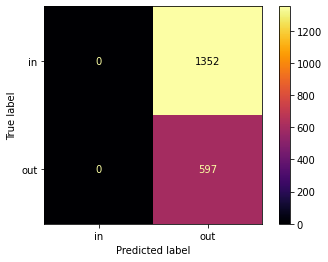

In [82]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

### with a nn instead of Adaboost for the shadow models

In [29]:
local_tree = load_pickle_bz2("decision_tree_adult96.bz2")
loaded     = np.load("decision_tree_adult_96.data.npz", allow_pickle=True)

In [30]:
X_train = loaded['X_train']
X_test  = loaded['X_test']
y_train = loaded['y_train']
y_test  = loaded['y_test']
full_generated_dataset = pd.read_csv("adult_lime_generated_around_0.csv")

In [28]:
from mlem.utilities import create_nn_model_keras

path="DT/shadow_nn_adult_dt"

shadow_models = ShadowModelsManager(
        n_models=4,
        results_path=f"{path}/shadow",
        test_size=0.5,
        random_state=123,
        model_creator_fn=create_nn_model_keras,
        categorical_mask=CATEGORICAL_FEATURES_MASK
    )

Fitting 4 shadow models on the data

In [37]:
shadow_models.fit(x_attack, y_attack)

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
2022-09-11 20:22:12.462625: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-09-11 20:22:12.462657: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: pop-os
2022-09-11 20:22:12.462661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: pop-os
2022-09-11 20:22:12.462795: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-09-11 20:22:12.462817:

Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 0.5788 - accuracy: 0.7339 - val_loss: 0.4397 - val_accuracy: 0.8495
Epoch 2/20
84/84 [==============================] - 0s 716us/step - loss: 0.3474 - accuracy: 0.8593 - val_loss: 0.2801 - val_accuracy: 0.8997
Epoch 3/20
84/84 [==============================] - 0s 722us/step - loss: 0.2475 - accuracy: 0.9062 - val_loss: 0.2022 - val_accuracy: 0.9331
Epoch 4/20
84/84 [==============================] - 0s 730us/step - loss: 0.1911 - accuracy: 0.9263 - val_loss: 0.1525 - val_accuracy: 0.9498
Epoch 5/20
84/84 [==============================] - 0s 740us/step - loss: 0.1569 - accuracy: 0.9375 - val_loss: 0.1253 - val_accuracy: 0.9632
Epoch 6/20
84/84 [==============================] - 0s 738us/step - loss: 0.1323 - accuracy: 0.9527 - val_loss: 0.1094 - val_accuracy: 0.9699
Epoch 7/20
84/84 [==============================] - 0s 723us/step - loss: 0.1169 - accuracy: 0.9576 - val_loss: 0.1006 - val_accuracy: 0.9699
Epoch 8/

2022-09-11 20:22:14.620038: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:tensorflow:Assets written to: ram://138a0902-0487-40e8-8502-ab4d04f17251/assets


Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 0.6088 - accuracy: 0.6770 - val_loss: 0.4681 - val_accuracy: 0.8227
Epoch 2/20
84/84 [==============================] - 0s 715us/step - loss: 0.3806 - accuracy: 0.8705 - val_loss: 0.2780 - val_accuracy: 0.8796
Epoch 3/20
84/84 [==============================] - 0s 717us/step - loss: 0.2454 - accuracy: 0.9096 - val_loss: 0.2000 - val_accuracy: 0.9398
Epoch 4/20
84/84 [==============================] - 0s 694us/step - loss: 0.1816 - accuracy: 0.9401 - val_loss: 0.1628 - val_accuracy: 0.9498
Epoch 5/20
84/84 [==============================] - 0s 715us/step - loss: 0.1384 - accuracy: 0.9539 - val_loss: 0.1422 - val_accuracy: 0.9465
Epoch 6/20
84/84 [==============================] - 0s 711us/step - loss: 0.1159 - accuracy: 0.9572 - val_loss: 0.1362 - val_accuracy: 0.9398
Epoch 7/20
84/84 [==============================] - 0s 718us/step - loss: 0.1039 - accuracy: 0.9643 - val_loss: 0.1205 - val_accuracy: 0.9532
Epoch 8/

INFO:tensorflow:Assets written to: ram://c3ba5481-2f2a-4c0d-9538-fc31788bf3f7/assets


Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 0.5468 - accuracy: 0.7168 - val_loss: 0.4260 - val_accuracy: 0.8094
Epoch 2/20
84/84 [==============================] - 0s 714us/step - loss: 0.3237 - accuracy: 0.8578 - val_loss: 0.2908 - val_accuracy: 0.8763
Epoch 3/20
84/84 [==============================] - 0s 709us/step - loss: 0.2305 - accuracy: 0.9088 - val_loss: 0.2076 - val_accuracy: 0.9164
Epoch 4/20
84/84 [==============================] - 0s 716us/step - loss: 0.1742 - accuracy: 0.9356 - val_loss: 0.1681 - val_accuracy: 0.9298
Epoch 5/20
84/84 [==============================] - 0s 703us/step - loss: 0.1389 - accuracy: 0.9516 - val_loss: 0.1304 - val_accuracy: 0.9398
Epoch 6/20
84/84 [==============================] - 0s 723us/step - loss: 0.1168 - accuracy: 0.9561 - val_loss: 0.1118 - val_accuracy: 0.9465
Epoch 7/20
84/84 [==============================] - 0s 738us/step - loss: 0.1075 - accuracy: 0.9579 - val_loss: 0.1107 - val_accuracy: 0.9465
Epoch 8/

INFO:tensorflow:Assets written to: ram://afc8b96d-c2de-4171-8036-83ce8e5c487d/assets


Epoch 1/20
84/84 [==============================] - 0s 2ms/step - loss: 0.5409 - accuracy: 0.7689 - val_loss: 0.4294 - val_accuracy: 0.8194
Epoch 2/20
84/84 [==============================] - 0s 715us/step - loss: 0.3424 - accuracy: 0.8597 - val_loss: 0.2841 - val_accuracy: 0.8662
Epoch 3/20
84/84 [==============================] - 0s 704us/step - loss: 0.2407 - accuracy: 0.9066 - val_loss: 0.2117 - val_accuracy: 0.9097
Epoch 4/20
84/84 [==============================] - 0s 699us/step - loss: 0.1792 - accuracy: 0.9356 - val_loss: 0.1672 - val_accuracy: 0.9431
Epoch 5/20
84/84 [==============================] - 0s 708us/step - loss: 0.1438 - accuracy: 0.9490 - val_loss: 0.1453 - val_accuracy: 0.9565
Epoch 6/20
84/84 [==============================] - 0s 716us/step - loss: 0.1240 - accuracy: 0.9539 - val_loss: 0.1398 - val_accuracy: 0.9465
Epoch 7/20
84/84 [==============================] - 0s 714us/step - loss: 0.1135 - accuracy: 0.9553 - val_loss: 0.1255 - val_accuracy: 0.9498
Epoch 8/

INFO:tensorflow:Assets written to: ram://271d832a-c9ec-4220-9183-0a662cdfa456/assets


In [38]:
attack_dataset_nn = shadow_models.get_attack_dataset()
attack_dataset_nn

,0,1,label,inout
0,0.000000,1.000000,1,in
1,0.999884,0.000116,0,in
2,0.999529,0.000471,0,in
3,0.113125,0.886875,1,in
4,0.992914,0.007086,0,in
...,...,...,...,...
2975,0.998204,0.001796,0,out
2976,0.329376,0.670624,1,out
2977,0.996248,0.003752,0,out
2978,0.999987,0.000013,0,out


In [39]:
attack_dataset_nn[attack_dataset_nn.label == 0][[0,1]].describe()

,0,1
count,11948.000000,1.194800e+04
mean,0.946618,5.338245e-02
std,0.161259,1.612586e-01
min,0.000078,1.427924e-07
25%,0.990823,1.617000e-04
50%,0.999027,9.729266e-04
75%,0.999838,9.176798e-03
max,1.000000,9.999218e-01


In [40]:
attack_dataset_nn[attack_dataset_nn.label == 1][[0,1]].describe()

,0,1
count,11916.000000,11916.000000
mean,0.051763,0.948237
std,0.144050,0.144050
min,0.000000,0.003020
25%,0.000000,0.984823
50%,0.000002,0.999998
75%,0.015177,1.000000
max,0.996980,1.000000


In [41]:
attack_dataset_nn[attack_dataset_nn.inout == 'in'][[0,1]].describe()

,0,1
count,11944.000000,1.194400e+04
mean,0.500771,4.992286e-01
std,0.473440,4.734397e-01
min,0.000000,1.427924e-07
25%,0.000003,9.981766e-04
50%,0.476871,5.231291e-01
75%,0.999002,9.999973e-01
max,1.000000,1.000000e+00


In [42]:
attack_dataset_nn[attack_dataset_nn.inout == 'out'][[0,1]].describe()

,0,1
count,11920.000000,1.192000e+04
mean,0.498807,5.011931e-01
std,0.472259,4.722594e-01
min,0.000000,1.947941e-07
25%,0.000002,9.400323e-04
50%,0.440931,5.590688e-01
75%,0.999060,9.999982e-01
max,1.000000,1.000000e+00


In [43]:
attack_dataset_ins_nn = attack_dataset_nn[attack_dataset_nn.inout == 'in']#.drop('inout', axis=1)
attack_dataset_outs_nn = attack_dataset_nn[attack_dataset_nn.inout == 'out']#.drop('inout', axis=1)

Creating the attack models, one for each label

In [54]:
from mlem.attack_models import AttackModelsManager, AttackStrategy
from mlem.utilities import create_adaboost

attack_models = AttackModelsManager(
        results_path=f"DT/attack_nn_adult_dt", model_creator_fn=create_adaboost, attack_strategy=AttackStrategy.ONE_PER_LABEL
)

In [55]:
attack_dataset_nn

,0,1,label,inout
0,0.000000,1.000000,1,in
1,0.999884,0.000116,0,in
2,0.999529,0.000471,0,in
3,0.113125,0.886875,1,in
4,0.992914,0.007086,0,in
...,...,...,...,...
2975,0.998204,0.001796,0,out
2976,0.329376,0.670624,1,out
2977,0.996248,0.003752,0,out
2978,0.999987,0.000013,0,out


In [56]:
attack_models.fit(attack_dataset_nn)

[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling
[INFO OVERSAMPLE] Specified ratio too low: skipping oversampling


In [57]:
atk_0 = load_pickle_bz2("DT/attack_nn_adult_dt/0/model.pkl.bz2")
atk_1 = load_pickle_bz2("DT/attack_nn_adult_dt/1/model.pkl.bz2")

### Attack on the whole datasets of the BB

In [58]:
BB_TRAIN = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_TRAIN['Target'] = BLACK_BOX_DATA['y_train']

BB_TEST = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_TEST['Target'] = BLACK_BOX_DATA['y_test']

In [59]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [60]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [61]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [62]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [63]:
BB_TRAIN_0

,0,1,ATK,Y
0,0.803145,0.196855,in,in
1,0.888638,0.111362,out,in
2,0.990708,0.009292,in,in
3,0.997404,0.002596,in,in
4,0.983742,0.016258,in,in
...,...,...,...,...
12669,0.788110,0.211890,in,in
12670,0.977904,0.022096,in,in
12671,0.997384,0.002616,in,in
12672,0.371998,0.628002,out,in


In [64]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [65]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.70      0.68      0.69     16877
         out       0.30      0.32      0.31      7234

    accuracy                           0.57     24111
   macro avg       0.50      0.50      0.50     24111
weighted avg       0.58      0.57      0.58     24111



In [66]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     4915
out    2319
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f28d1769970>


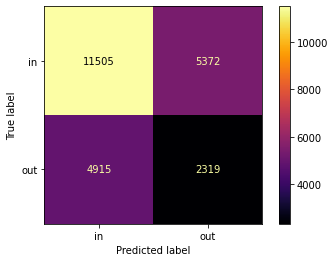

In [67]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

Let's see on the points closest to the instance used to create the neighborhood

In [68]:
import scipy.spatial.distance as distance

In [69]:
BB_DATA_TR = pd.DataFrame(BLACK_BOX_DATA['x_train'])
BB_DATA_TR['Target'] = BLACK_BOX_DATA['y_train']
BB_DATA_TR['Distance'] = distance.cdist(BLACK_BOX_DATA['x_train'], [X], metric="euclidean")

BB_DATA_TE = pd.DataFrame(BLACK_BOX_DATA['x_test'])
BB_DATA_TE['Target'] = BLACK_BOX_DATA['y_test']
BB_DATA_TE['Distance'] = distance.cdist(BLACK_BOX_DATA['x_test'], [X], metric="euclidean")

In [70]:
BB_DATA_TR.Distance.describe()

count    16877.000000
mean         2.501770
std          1.457291
min          0.085012
25%          1.649780
50%          2.275654
75%          3.035977
max         14.413855
Name: Distance, dtype: float64

In [71]:
BB_DATA_TE.Distance.describe()

count    7234.000000
mean        2.496813
std         1.418222
min         0.000000
25%         1.648631
50%         2.278651
75%         3.053983
max        14.435124
Name: Distance, dtype: float64

In [72]:
BB_DATA_TR[BB_DATA_TR.Distance < 2.5].Target.value_counts(normalize=True)

0    0.846397
1    0.153603
Name: Target, dtype: float64

In [73]:
BB_DATA_TE[BB_DATA_TE.Distance < 3].Target.value_counts(normalize=True)

0    0.810058
1    0.189942
Name: Target, dtype: float64

Creating the dataset with the closest points

In [74]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 2.5].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 3].drop('Distance', axis=1)

In [75]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [76]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [77]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [78]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [79]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [80]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.65      0.71      0.68      9824
         out       0.37      0.31      0.34      5349

    accuracy                           0.57     15173
   macro avg       0.51      0.51      0.51     15173
weighted avg       0.55      0.57      0.56     15173



In [81]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     3703
out    1646
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f28d02d8d30>


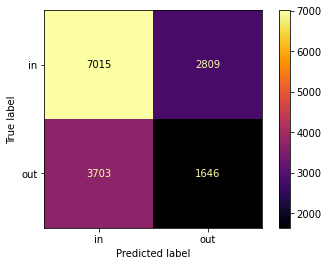

In [82]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')

Creating dataset with points closer that 1

In [83]:
BB_TRAIN = BB_DATA_TR[BB_DATA_TR.Distance < 1].drop('Distance', axis=1)
BB_TEST = BB_DATA_TE[BB_DATA_TE.Distance < 1].drop('Distance', axis=1)

In [84]:
BB_TRAIN

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Target
44,-1.328265,0.218918,-0.354033,0.200180,-0.048076,0.048399,0.041134,0.106689,0.129972,0.113783,-0.147502,-0.218673,-0.912857,0.254411,0
46,-0.947492,0.218918,0.659777,0.200180,-0.048076,0.048399,0.041134,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
57,-1.023647,0.218918,-0.948069,0.164328,-0.440434,0.048399,0.133907,0.014343,0.277405,0.113783,-0.147502,-0.218673,-0.078031,0.254411,0
62,-1.099801,0.218918,0.330513,0.164328,-0.440434,0.048399,0.225590,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
65,-1.099801,0.218918,0.087226,0.164328,-0.440434,0.048399,0.225590,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16755,-1.175956,0.218918,-0.044380,0.164328,-0.440434,0.048399,0.061527,0.014343,0.129972,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
16773,-0.947492,0.218918,0.560257,0.200180,-0.048076,0.048399,0.225590,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0
16808,-1.099801,0.218918,-0.265832,0.164328,-0.440434,0.107312,0.485342,0.106689,0.263855,0.113783,-0.147502,-0.218673,0.339381,0.254411,1
16816,-1.480574,0.218918,-0.743568,0.164328,-0.440434,0.048399,0.270647,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,0.254411,0


In [85]:
BB_TEST

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Target
10,-1.328265,0.218918,0.452938,0.200180,-0.048076,0.048399,0.041134,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.495444,2.544112e-01,0
23,-0.719029,0.218918,-0.817391,0.164328,-0.440434,0.048399,0.225590,0.106689,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,0
53,-1.023647,0.268960,-0.304552,0.164328,-0.440434,0.048399,0.485342,0.106689,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,0
59,-1.252110,0.218918,0.235100,0.164328,-0.440434,0.048399,0.124236,0.106689,0.263855,0.313955,-0.147502,-0.218673,0.088934,2.544112e-01,0
86,-1.404419,0.218918,-0.048431,0.164328,-0.440434,0.048399,0.270647,0.106689,0.263855,0.113783,-0.147502,-0.218673,-0.745892,2.544112e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7182,-1.175956,0.218918,0.266580,0.164328,-0.440434,0.048399,0.225590,0.066334,0.263855,0.313955,-0.147502,-0.218673,0.339381,5.629249e-07,0
7183,-1.175956,0.218918,-0.683458,0.164328,-0.440434,0.048399,0.225590,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,0
7186,-1.023647,0.218918,0.223525,0.200180,-0.048076,0.455011,0.270647,0.455728,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,1
7198,-0.871338,0.218918,-0.058264,0.164328,-0.440434,0.048399,0.202926,0.014343,0.263855,0.313955,-0.147502,-0.218673,-0.078031,2.544112e-01,0


In [86]:
BB_TEST_0 = BB_TEST[BB_TEST.Target == 0]
BB_TEST_1 = BB_TEST[BB_TEST.Target == 1]

BB_TRAIN_0 = BB_TRAIN[BB_TRAIN.Target == 0]
BB_TRAIN_1 = BB_TRAIN[BB_TRAIN.Target == 1]

In [87]:
BB_TEST_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_0.drop('Target', axis=1).to_numpy()))
BB_TEST_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TEST_1.drop('Target', axis=1).to_numpy()))
BB_TRAIN_0 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_0.drop('Target', axis=1).to_numpy()))
BB_TRAIN_1 = pd.DataFrame(BLACK_BOX.predict_proba(BB_TRAIN_1.drop('Target', axis=1).to_numpy()))

In [88]:
BB_TEST_0['ATK'] = atk_0.predict(BB_TEST_0.to_numpy())
BB_TEST_1['ATK'] = atk_1.predict(BB_TEST_1.to_numpy())
BB_TRAIN_0['ATK'] = atk_0.predict(BB_TRAIN_0.to_numpy())
BB_TRAIN_1['ATK'] = atk_1.predict(BB_TRAIN_1.to_numpy())

In [89]:
BB_TEST_0['Y'] = 'out'
BB_TEST_1['Y'] = 'out'
BB_TRAIN_0['Y'] = 'in'
BB_TRAIN_1['Y'] = 'in'

In [90]:
train_test = pd.concat([BB_TEST_0, BB_TEST_1,BB_TRAIN_0, BB_TRAIN_1])

In [91]:
print(classification_report(train_test.Y, train_test.ATK))

              precision    recall  f1-score   support

          in       0.70      0.71      0.70      1352
         out       0.32      0.31      0.31       597

    accuracy                           0.59      1949
   macro avg       0.51      0.51      0.51      1949
weighted avg       0.58      0.59      0.58      1949



In [92]:
train_test[train_test.Y == 'out'].ATK.value_counts()

in     412
out    185
Name: ATK, dtype: int64

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f28cfef8b50>


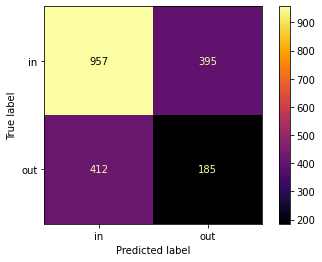

In [93]:
ConfusionMatrixDisplay.from_predictions(train_test.Y, train_test.ATK, cmap='inferno')